In [1]:
from utils import *
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import glob
from joblib import Parallel, delayed

In [2]:
#df

In [3]:
def get_baseline_max_min(df):
    df = load_robustnes('None')
    baselines = {}
    for dataset in df.dataset.unique():
        dfd = df.query(f'dataset=="{dataset}"').groupby(['dataset', 'method']).mean(numeric_only=True).reset_index()
        best = dfd['accuracy'].max()
        baseline = dfd.query('method=="baseline"')['accuracy'].mean()
        baselines[dataset] = (baseline, best)
    return baselines

def load_ce(df):
    baselines = get_baseline_max_min(df)
    c = df.groupby(['dataset', 'method', 'level']).mean(numeric_only=True).reset_index()
    #return c
    ces = {'dataset': [], 'method': [], 'level': [], 'ce': []}
    for row in c.itertuples():
        baseline, best = baselines[row.dataset]
        ce = (row.accuracy-baseline)/((best-baseline)+0.01)
        ces['dataset'].append(row.dataset)
        ces['method'].append(row.method)
        ces['level'].append(row.level)
        ces['ce'].append(ce)
    return pd.DataFrame(ces)
    


In [4]:
transform_name = 'TimeWarp'
x_axis_scale_type = 'log'
#x_axis_scale_type = 'linear'
#xlims = (10**-4, None)
xlims = (None, None)

In [5]:
df = load_robustnes(transform_name)
print(len(df.dataset.unique()))
df

Loaded 11067 files
128


dataset     method      transform  seed  accuracy  \
0                   Crop  inception   TimeWarp;1.0     0  0.097202   
0                    Car   baseline   TimeWarp;2.0     0  0.216667   
0                  Fungi  inception  TimeWarp;0.05     0  0.908602   
0          WormsTwoClass        cnn  TimeWarp;0.01     0  0.506494   
0               FaceFour    tsfresh   TimeWarp;0.1     0  0.511364   
..                   ...        ...            ...   ...       ...   
0              ShapesAll   baseline   TimeWarp;1.0     0  0.016667   
0                 ECG200        cnn  TimeWarp;0.02     0  0.830000   
0        GestureMidAirD3   tsforest  TimeWarp;0.01     0  0.492308   
0               CricketZ  inception   TimeWarp;0.1     0  0.720513   
0   RefrigerationDevices       eknn   TimeWarp;2.0     0  0.346667   

                                                 pred  \
0                             [ 1  4  1 ...  5 11  3]   
0   [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4...   
0   [ 1  1  1  1  1 18  1  2  2  2  2  2  2  2  1 ...   
0   [2 2 2 1 2 1 2 2 1 2 2 1 1 2 2 2 2 2 2 1 2 1 2...   
0   [3 1 2 2 2 1 2 4 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2...   
..                                                ...   
0   [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   
0   [ 1  1 -1  1 -1  1 -1  1  1 -1 -1  1  1 -1 -1 ...   
0   [19 13 17  8 26 21 25 19 19 24 11 26  2 26  7 ...   
0   [11  8 11 11  9 12  8 10 11 10  4  7  6 11 11 ...   
0   [2 1 3 3 1 2 1 2 3 3 2 2 2 3 3 3 3 2 2 2 2 2 3...   

                                                 true  level transform_type  
0                             [ 1  1  1 ... 24 24 24]   1.00   TimeWarp;1.0  
0   [4 3 2 3 4 3 4 4 2 4 1 1 1 3 4 3 3 4 2 4 2 2 3...   2.00   TimeWarp;2.0  
0   [ 1  1  1  1  1  1  1  2  2  2  2  2  2  2  2 ...   0.05  TimeWarp;0.05  
0   [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   0.01  TimeWarp;0.01  
0   [3 1 2 4 1 4 3 3 2 3 1 3 2 2 3 2 2 3 2 4 1 2 2...   0.10   TimeWarp;0.1  
..                                                ...    ...            ...  
0   [ 1  1  1  1  1  1  1  1  1  1  2  2  2  2  2 ...   1.00   TimeWarp;1.0  
0   [ 1  1  1  1 -1  1  1  1  1 -1 -1  1 -1 -1 -1 ...   0.02  TimeWarp;0.02  
0   [19 13 23  4 26 21  3 19 19 24  4 17 21 26  6 ...   0.01  TimeWarp;0.01  
0   [11 10 11  9  9 12  8 12 11 10  4  7 12  2  3 ...   0.10   TimeWarp;0.1  
0   [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   2.00   TimeWarp;2.0  

[11067 rows x 9 columns]

In [6]:
df = df.query('method.str.contains("-") == False', engine='python')

In [7]:
methods = df.method.unique()
methods

array(['inception', 'baseline', 'cnn', 'tsfresh', 'drcif', 'weasel',
       'catch22', 'tsforest', 'rocket', 'eknn', 'hivecotev2'],
      dtype=object)

In [8]:
df = filter_out_incomplete_datasets(df)
df

['inception' 'baseline' 'cnn' 'tsfresh' 'drcif' 'weasel' 'catch22'
 'tsforest' 'rocket' 'eknn' 'hivecotev2']
['TimeWarp;1.0' 'TimeWarp;2.0' 'TimeWarp;0.05' 'TimeWarp;0.01'
 'TimeWarp;0.1' 'TimeWarp;0.5' 'TimeWarp;0.02' 'TimeWarp;0.2']
88
not complete datasets: {'OSULeaf', 'Herring', 'InsectWingbeatSound', 'ItalyPowerDemand', 'MixedShapesRegularTrain', 'ECG5000', 'FreezerRegularTrain', 'ECGFiveDays', 'ChlorineConcentration', 'FaceAll', 'Wafer', 'CBF', 'Crop', 'StarLightCurves', 'OliveOil', 'FacesUCR', 'Adiac', 'Wine', 'MelbournePedestrian', 'NonInvasiveFetalECGThorax1', 'CinCECGTorso', 'FreezerSmallTrain', 'Phoneme', 'UWaveGestureLibraryZ', 'EOGVerticalSignal', 'MoteStrain', 'Fungi', 'SmoothSubspace', 'Rock', 'MixedShapesSmallTrain', 'InsectEPGRegularTrain', 'NonInvasiveFetalECGThorax2', 'UWaveGestureLibraryY', 'ProximalPhalanxTW', 'TwoPatterns', 'Mallat', 'UWaveGestureLibraryAll', 'Worms', 'EthanolLevel', 'TwoLeadECG', 'Yoga', 'SemgHandSubjectCh2', 'UWaveGestureLibraryX', 'SwedishLeaf'

dataset     method      transform  seed  accuracy  \
0                    Car   baseline   TimeWarp;2.0     0  0.216667   
0          WormsTwoClass        cnn  TimeWarp;0.01     0  0.506494   
0               FaceFour    tsfresh   TimeWarp;0.1     0  0.511364   
0              PowerCons     weasel  TimeWarp;0.02     0  0.911111   
0               FaceFour    catch22   TimeWarp;0.2     0  0.306818   
..                   ...        ...            ...   ...       ...   
0              ShapesAll   baseline   TimeWarp;1.0     0  0.016667   
0                 ECG200        cnn  TimeWarp;0.02     0  0.830000   
0        GestureMidAirD3   tsforest  TimeWarp;0.01     0  0.492308   
0               CricketZ  inception   TimeWarp;0.1     0  0.720513   
0   RefrigerationDevices       eknn   TimeWarp;2.0     0  0.346667   

                                                 pred  \
0   [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4...   
0   [2 2 2 1 2 1 2 2 1 2 2 1 1 2 2 2 2 2 2 1 2 1 2...   
0   [3 1 2 2 2 1 2 4 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2...   
0   [1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   
0   [2 4 2 1 1 1 1 2 1 2 1 1 2 2 2 1 1 2 1 1 1 2 1...   
..                                                ...   
0   [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   
0   [ 1  1 -1  1 -1  1 -1  1  1 -1 -1  1  1 -1 -1 ...   
0   [19 13 17  8 26 21 25 19 19 24 11 26  2 26  7 ...   
0   [11  8 11 11  9 12  8 10 11 10  4  7  6 11 11 ...   
0   [2 1 3 3 1 2 1 2 3 3 2 2 2 3 3 3 3 2 2 2 2 2 3...   

                                                 true  level transform_type  
0   [4 3 2 3 4 3 4 4 2 4 1 1 1 3 4 3 3 4 2 4 2 2 3...   2.00   TimeWarp;2.0  
0   [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   0.01  TimeWarp;0.01  
0   [3 1 2 4 1 4 3 3 2 3 1 3 2 2 3 2 2 3 2 4 1 2 2...   0.10   TimeWarp;0.1  
0   [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   0.02  TimeWarp;0.02  
0   [3 1 2 4 1 4 3 3 2 3 1 3 2 2 3 2 2 3 2 4 1 2 2...   0.20   TimeWarp;0.2  
..                                                ...    ...            ...  
0   [ 1  1  1  1  1  1  1  1  1  1  2  2  2  2  2 ...   1.00   TimeWarp;1.0  
0   [ 1  1  1  1 -1  1  1  1  1 -1 -1  1 -1 -1 -1 ...   0.02  TimeWarp;0.02  
0   [19 13 23  4 26 21  3 19 19 24  4 17 21 26  6 ...   0.01  TimeWarp;0.01  
0   [11 10 11  9  9 12  8 12 11 10  4  7 12  2  3 ...   0.10   TimeWarp;0.1  
0   [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   2.00   TimeWarp;2.0  

[6424 rows x 9 columns]

In [9]:
cedf = load_ce(df)

Loaded 1700 files


In [10]:
df

dataset     method      transform  seed  accuracy  \
0                    Car   baseline   TimeWarp;2.0     0  0.216667   
0          WormsTwoClass        cnn  TimeWarp;0.01     0  0.506494   
0               FaceFour    tsfresh   TimeWarp;0.1     0  0.511364   
0              PowerCons     weasel  TimeWarp;0.02     0  0.911111   
0               FaceFour    catch22   TimeWarp;0.2     0  0.306818   
..                   ...        ...            ...   ...       ...   
0              ShapesAll   baseline   TimeWarp;1.0     0  0.016667   
0                 ECG200        cnn  TimeWarp;0.02     0  0.830000   
0        GestureMidAirD3   tsforest  TimeWarp;0.01     0  0.492308   
0               CricketZ  inception   TimeWarp;0.1     0  0.720513   
0   RefrigerationDevices       eknn   TimeWarp;2.0     0  0.346667   

                                                 pred  \
0   [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4...   
0   [2 2 2 1 2 1 2 2 1 2 2 1 1 2 2 2 2 2 2 1 2 1 2...   
0   [3 1 2 2 2 1 2 4 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2...   
0   [1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   
0   [2 4 2 1 1 1 1 2 1 2 1 1 2 2 2 1 1 2 1 1 1 2 1...   
..                                                ...   
0   [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   
0   [ 1  1 -1  1 -1  1 -1  1  1 -1 -1  1  1 -1 -1 ...   
0   [19 13 17  8 26 21 25 19 19 24 11 26  2 26  7 ...   
0   [11  8 11 11  9 12  8 10 11 10  4  7  6 11 11 ...   
0   [2 1 3 3 1 2 1 2 3 3 2 2 2 3 3 3 3 2 2 2 2 2 3...   

                                                 true  level transform_type  
0   [4 3 2 3 4 3 4 4 2 4 1 1 1 3 4 3 3 4 2 4 2 2 3...   2.00   TimeWarp;2.0  
0   [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   0.01  TimeWarp;0.01  
0   [3 1 2 4 1 4 3 3 2 3 1 3 2 2 3 2 2 3 2 4 1 2 2...   0.10   TimeWarp;0.1  
0   [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   0.02  TimeWarp;0.02  
0   [3 1 2 4 1 4 3 3 2 3 1 3 2 2 3 2 2 3 2 4 1 2 2...   0.20   TimeWarp;0.2  
..                                                ...    ...            ...  
0   [ 1  1  1  1  1  1  1  1  1  1  2  2  2  2  2 ...   1.00   TimeWarp;1.0  
0   [ 1  1  1  1 -1  1  1  1  1 -1 -1  1 -1 -1 -1 ...   0.02  TimeWarp;0.02  
0   [19 13 23  4 26 21  3 19 19 24  4 17 21 26  6 ...   0.01  TimeWarp;0.01  
0   [11 10 11  9  9 12  8 12 11 10  4  7 12  2  3 ...   0.10   TimeWarp;0.1  
0   [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   2.00   TimeWarp;2.0  

[6424 rows x 9 columns]

In [11]:
pdf = df.pivot_table(index=['dataset', 'level', 'seed'], 
                          columns='method', 
                          values='accuracy',
                          aggfunc='mean').reset_index()
pdf

method        dataset  level  seed  baseline   catch22       cnn     drcif  \
0               ACSF1   0.01     0  0.100000  0.340000  0.100000  0.140000   
1               ACSF1   0.02     0  0.100000  0.380000  0.100000  0.170000   
2               ACSF1   0.05     0  0.100000  0.270000  0.100000  0.150000   
3               ACSF1   0.10     0  0.100000  0.230000  0.100000  0.100000   
4               ACSF1   0.20     0  0.100000  0.240000  0.100000  0.090000   
..                ...    ...   ...       ...       ...       ...       ...   
579     WormsTwoClass   0.10     0  0.571429  0.649351  0.545455  0.779221   
580     WormsTwoClass   0.20     0  0.571429  0.610390  0.636364  0.753247   
581     WormsTwoClass   0.50     0  0.571429  0.506494  0.493506  0.701299   
582     WormsTwoClass   1.00     0  0.571429  0.532468  0.441558  0.649351   
583     WormsTwoClass   2.00     0  0.571429  0.493506  0.623377  0.623377   

method      eknn  hivecotev2  inception    rocket  tsforest   tsfresh  \
0       0.110000    0.130000   0.160000  0.130000  0.150000  0.410000   
1       0.130000    0.120000   0.100000  0.100000  0.140000  0.420000   
2       0.140000    0.150000   0.100000  0.100000  0.140000  0.330000   
3       0.140000    0.130000   0.090000  0.100000  0.150000  0.270000   
4       0.090000    0.140000   0.100000  0.120000  0.120000  0.220000   
..           ...         ...        ...       ...       ...       ...   
579     0.519481    0.740260   0.688312  0.727273  0.688312  0.805195   
580     0.467532    0.675325   0.675325  0.688312  0.610390  0.766234   
581     0.558442    0.597403   0.636364  0.558442  0.493506  0.701299   
582     0.519481    0.558442   0.558442  0.493506  0.532468  0.675325   
583     0.506494    0.545455   0.623377  0.558442  0.493506  0.532468   

method    weasel  
0       0.130000  
1       0.150000  
2       0.130000  
3       0.110000  
4       0.100000  
..           ...  
579     0.558442  
580     0.714286  
581     0.623377  
582     0.519481  
583     0.532468  

[584 rows x 14 columns]

In [12]:
ranked_df = pdf[methods].rank(axis=1, ascending=False)
pdf[methods] = ranked_df
pdf

method        dataset  level  seed  baseline  catch22   cnn  drcif  eknn  \
0               ACSF1   0.01     0      10.5      2.0  10.5    5.0   9.0   
1               ACSF1   0.02     0       9.5      2.0   9.5    3.0   6.0   
2               ACSF1   0.05     0       9.5      2.0   9.5    3.5   5.5   
3               ACSF1   0.10     0       8.5      2.0   8.5    8.5   4.0   
4               ACSF1   0.20     0       7.5      1.0   7.5   10.5  10.5   
..                ...    ...   ...       ...      ...   ...    ...   ...   
579     WormsTwoClass   0.10     0       8.0      7.0  10.0    2.0  11.0   
580     WormsTwoClass   0.20     0      10.0      8.5   7.0    2.0  11.0   
581     WormsTwoClass   0.50     0       6.0      9.0  10.5    1.5   7.5   
582     WormsTwoClass   1.00     0       3.0      6.5  11.0    2.0   8.5   
583     WormsTwoClass   2.00     0       4.0     10.5   2.0    2.0   9.0   

method  hivecotev2  inception  rocket  tsforest  tsfresh  weasel  
0              7.0        3.0     7.0       4.0      1.0     7.0  
1              7.0        9.5     9.5       5.0      1.0     4.0  
2              3.5        9.5     9.5       5.5      1.0     7.0  
3              5.0       11.0     8.5       3.0      1.0     6.0  
4              3.0        7.5     4.5       4.5      2.0     7.5  
..             ...        ...     ...       ...      ...     ...  
579            3.0        5.5     4.0       5.5      1.0     9.0  
580            5.5        5.5     4.0       8.5      1.0     3.0  
581            5.0        3.0     7.5      10.5      1.5     4.0  
582            4.5        4.5    10.0       6.5      1.0     8.5  
583            6.0        2.0     5.0      10.5      7.5     7.5  

[584 rows x 14 columns]

In [13]:
gpdf = pdf.groupby('level').mean(numeric_only=True).reset_index()

In [14]:
gpdf

method  level  seed   baseline   catch22       cnn     drcif      eknn  \
0        0.01   0.0  10.616438  7.157534  8.712329  3.897260  8.349315   
1        0.02   0.0  10.575342  6.904110  8.568493  3.650685  8.267123   
2        0.05   0.0  10.034247  6.554795  8.979452  3.869863  8.410959   
3        0.10   0.0   9.705479  6.075342  8.623288  4.273973  8.424658   
4        0.20   0.0   9.253425  6.308219  8.294521  4.253425  8.595890   
5        0.50   0.0   8.657534  5.904110  7.965753  4.917808  8.616438   
6        1.00   0.0   8.301370  5.904110  7.979452  4.958904  8.253425   
7        2.00   0.0   7.965753  5.965753  7.205479  5.342466  8.041096   

method  hivecotev2  inception    rocket  tsforest   tsfresh    weasel  
0         2.109589   4.068493  3.130137  5.993151  6.082192  5.883562  
1         2.287671   4.205479  3.390411  6.513699  5.883562  5.753425  
2         2.849315   3.890411  3.698630  6.616438  5.376712  5.719178  
3         3.273973   3.664384  4.342466  6.897260  4.794521  5.924658  
4         3.260274   4.027397  4.301370  7.013699  4.602740  6.089041  
5         4.123288   3.856164  4.739726  6.835616  4.561644  5.821918  
6         4.068493   4.041096  5.143836  6.232877  5.061644  6.054795  
7         4.801370   4.308219  5.239726  6.061644  5.452055  5.616438

In [15]:
#plt.figure(figsize=(12, 4))
#
#for method in methods:
#    #print(method)
#    h = gpdf.sort_values('level')
#    plt.plot(h['level'], h[method], label=method, **display_mapped_fields[method])
#
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=(int(len(methods))/2)+1)
#plt.xlabel(f'{transform_name} level')
#plt.ylabel('Rank')
#
#plt.xscale(x_axis_scale_type)
#
#plt.grid()
#plt.savefig(f'figures/{transform_name}_rank.pdf', bbox_inches='tight', pad_inches=0)

In [16]:
gcedf = cedf.groupby(['method', 'level']).mean(numeric_only=True).reset_index()
gcedf

method  level        ce
0   baseline   0.01  0.000000
1   baseline   0.02  0.000000
2   baseline   0.05  0.000000
3   baseline   0.10  0.000000
4   baseline   0.20  0.000000
..       ...    ...       ...
83    weasel   0.10  0.285597
84    weasel   0.20  0.131541
85    weasel   0.50 -0.223720
86    weasel   1.00 -0.331494
87    weasel   2.00 -0.492302

[88 rows x 3 columns]

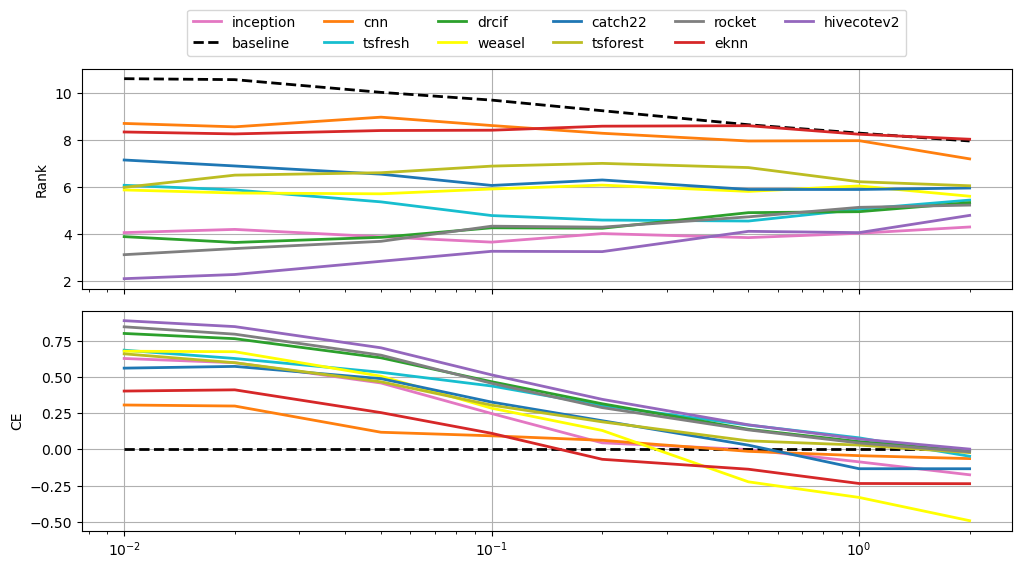

In [17]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

for method in methods:
    h = gpdf.sort_values('level')
    ax1.plot(h['level'], h[method], label=method, **display_mapped_fields[method])

for method in methods:
    h = gcedf.query(f'method=="{method}"').sort_values('level')
    ax2.plot(h['level'], h['ce'], label=method, **display_mapped_fields[method])

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.30), ncol=(int(len(methods))/2)+1)
#ax1.set_xlabel(f'{transform_name} level')
ax1.set_ylabel('Rank')
ax1.set_xscale(x_axis_scale_type)
ax1.grid()

ax2.set_ylabel('CE')
ax2.set_xscale(x_axis_scale_type)
ax2.grid()

fig.subplots_adjust(hspace=0.1)
ax1.set_xlim(*xlims)
ax2.set_xlim(*xlims)
plt.savefig(f'figures/{transform_name}_combined.pdf', bbox_inches='tight', pad_inches=0)